In [ ]:
install.packages("rpart.plot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Arbol elemental con libreria  rpart
# Debe tener instaladas las librerias  data.table  ,  rpart  y  rpart.plot

# cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")

In [ ]:
library(ggplot2)

In [ ]:
# cargo el dataset
dataset <- fread("data_end3.csv")

In [ ]:
num_rows <- nrow(dataset)
num_rows

[1] 491063

In [ ]:
dataset <- subset(dataset, select = -c(pesos_cta_corriente, pesos_caja_ahorro))

In [ ]:
dtrain <- dataset[foto_mes == 202103] # defino donde voy a entrenar
dapply <- dataset[foto_mes == 202105] # defino donde voy a aplicar el modelo

In [ ]:
nrow(dapply)

[1] 164102

In [ ]:
set.seed(200779)

# genero el modelo,  aqui se construye el arbol
# quiero predecir clase_ternaria a partir de el resto de las variables
modelo <- rpart(
        formula = "clase_ternaria ~ .",
        data = dtrain, # los datos donde voy a entrenar
        xval = 5, #k fold 5
        cp = -1, # esto significa no limitar la complejidad de los splits
        minsplit = 1500, # minima cantidad de registros para que se haga el split
        minbucket = 500, # tamaño minimo de una hoja
        maxdepth = 30
) # profundidad maxima del arbol

Warning message:
“labs do not fit even at cex 0.15, there may be some overplotting”


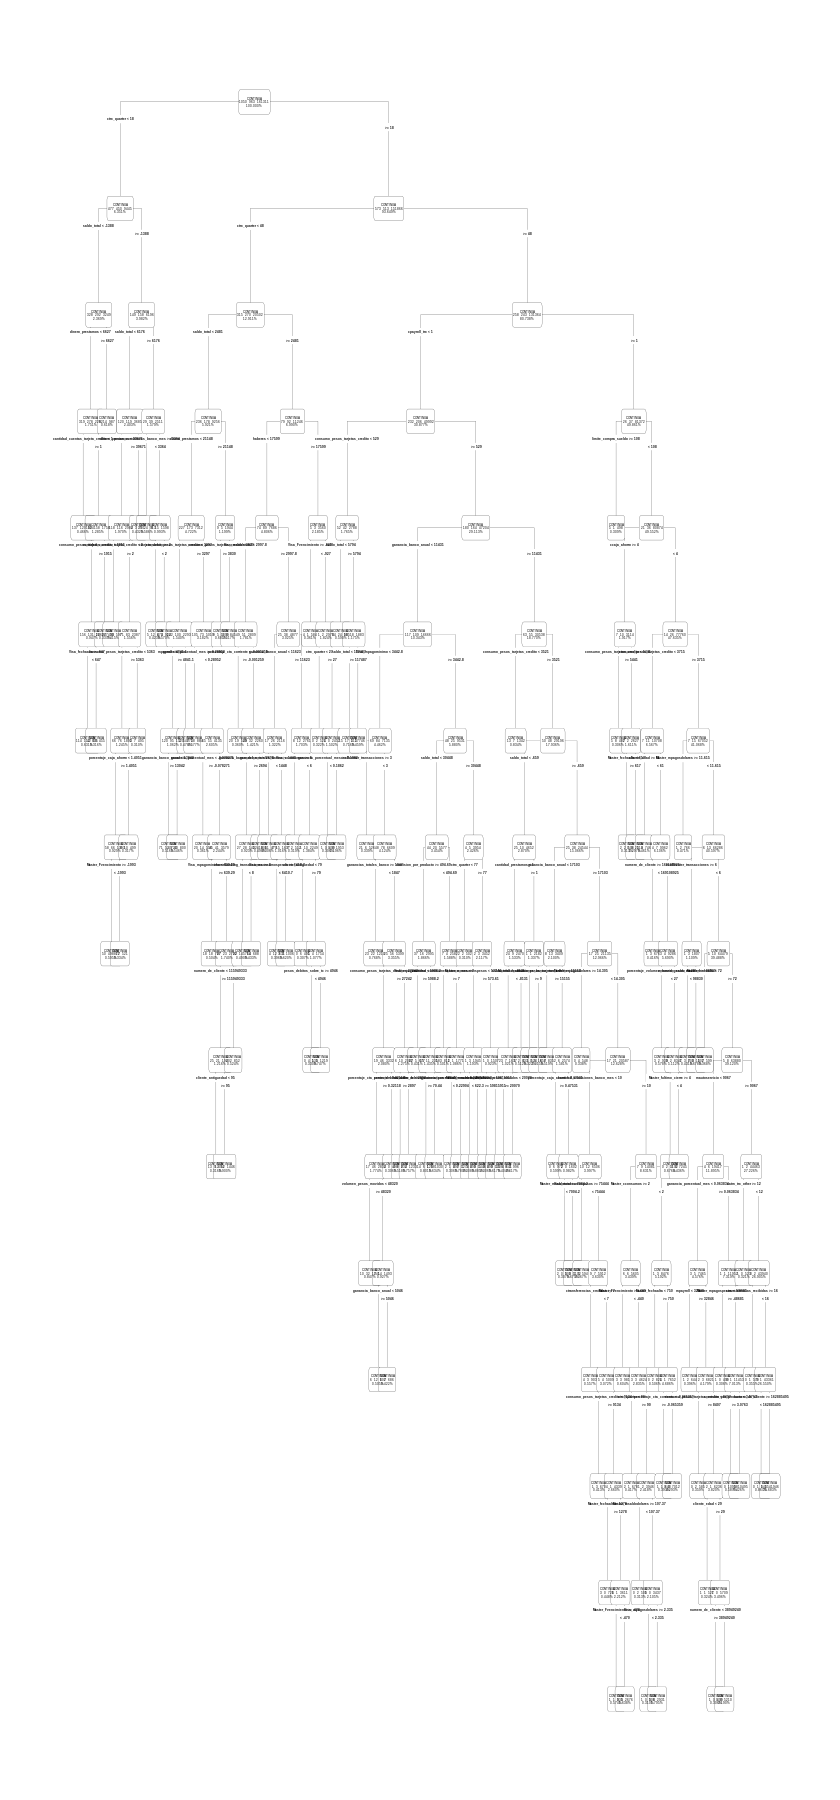

In [ ]:
 # grafico el arbol
prp(modelo,
        extra = 101, digits = -5,
        branch = 1, type = 4, varlen = 0, faclen = 0
)

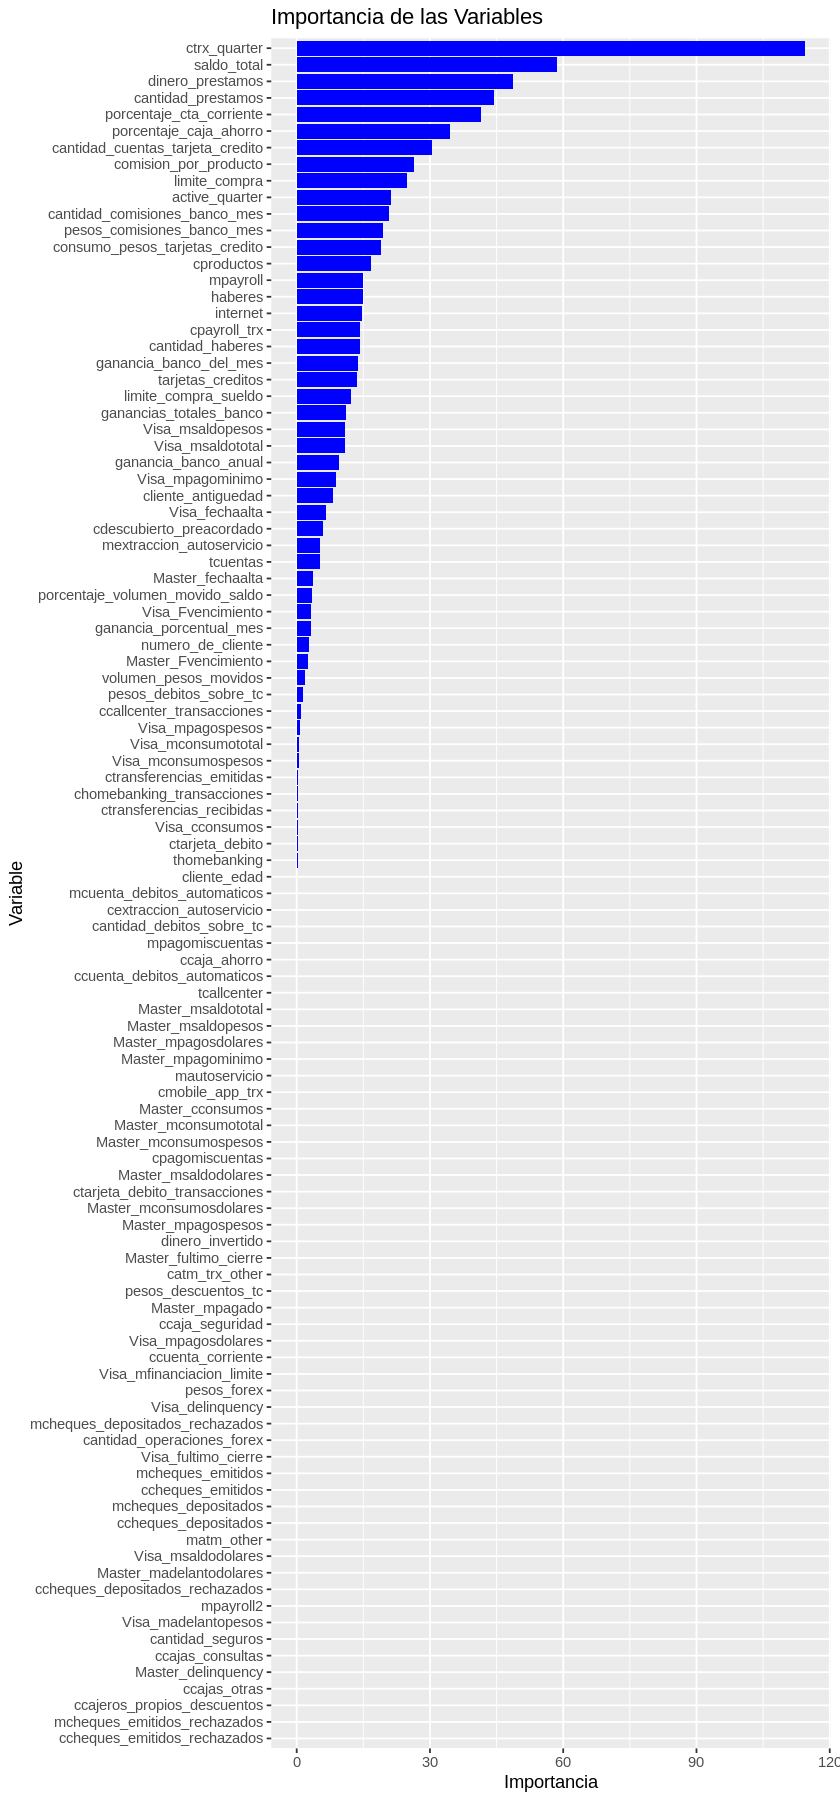

In [ ]:
# Access the variable importance
var_importance <- modelo$variable.importance

# Create a data frame for plotting
importance_df <- data.frame(
  Variable = names(var_importance),
  Importance = var_importance
)

# Sort the data frame by importance
importance_df <- importance_df[order(importance_df$Importance, decreasing = TRUE), ]

# Crear un gráfico de barras con mayor altura
options(repr.plot.height=15)  # Ajusta la altura aquí

ggplot(importance_df, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "blue") +
  coord_flip() +
  labs(title = "Importancia de las Variables", x = "Variable", y = "Importancia")


In [ ]:
#var_importance <- modelo$variable.importance

# Print the variable importance
#print(var_importance)

In [ ]:
# aplico el modelo a los datos nuevos
prediccion <- predict(
        object = modelo,
        newdata = dapply,
        type = "prob"
)

In [ ]:
# prediccion es una matriz con TRES columnas,
# llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
# cada columna es el vector de probabilidades

# agrego a dapply una columna nueva que es la probabilidad de BAJA+2
dapply[, prob_baja2 := prediccion[, "BAJA+2"]]

# solo le envio estimulo a los registros
#  con probabilidad de BAJA+2 mayor  a  1/40
dapply[, Predicted := as.numeric(prob_baja2 > 1 / 40)]

# genero el archivo para Kaggle
# primero creo la carpeta donde va el experimento
##dir.create("./exp/")
##dir.create("./exp/KA2001")

# solo los campos para Kaggle
fwrite(dapply[, list(numero_de_cliente, Predicted)],
        file = "./exp/KA2001/K101_011.csv",
        sep = ","
)